In [41]:
# 텐서플로우 디바이스 목록 출력
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5573214089747750977
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6284115968
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8146922417679487675
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [42]:
# GPU 사용
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [43]:
import numpy as np

actions = [
    'pgup',
    'pgdn',
    'reset'
]

data = np.concatenate([
    np.load('dataset/seq_pgup_1686036035.npy'),
    np.load('dataset/seq_pgdn_1686036035.npy'),
    np.load('dataset/seq_reset_1686036035.npy')
], axis=0)

data.shape

(2575, 30, 100)

In [44]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2575, 30, 99)
(2575,)


In [45]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2575, 3)

In [46]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2023)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2317, 30, 99) (2317, 3)
(258, 30, 99) (258, 3)


In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                41984     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=500,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/500
71/73 [============================>.] - ETA: 0s - loss: 0.1664 - acc: 0.9846
Epoch 1: val_acc improved from -inf to 1.00000, saving model to models\model.h5
73/73 [==============================] - 3s 12ms/step - loss: 0.1634 - acc: 0.9849 - val_loss: 0.0081 - val_acc: 1.0000 - lr: 0.0010
Epoch 2/500
73/73 [==============================] - ETA: 0s - loss: 0.0043 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
73/73 [==============================] - 0s 7ms/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000 - lr: 0.0010
Epoch 3/500
71/73 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
73/73 [==============================] - 0s 7ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 9.4579e-04 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/500
65/73 [=========================>....] - ETA: 0s - loss: 7.7536e-04 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
73/73 [==========

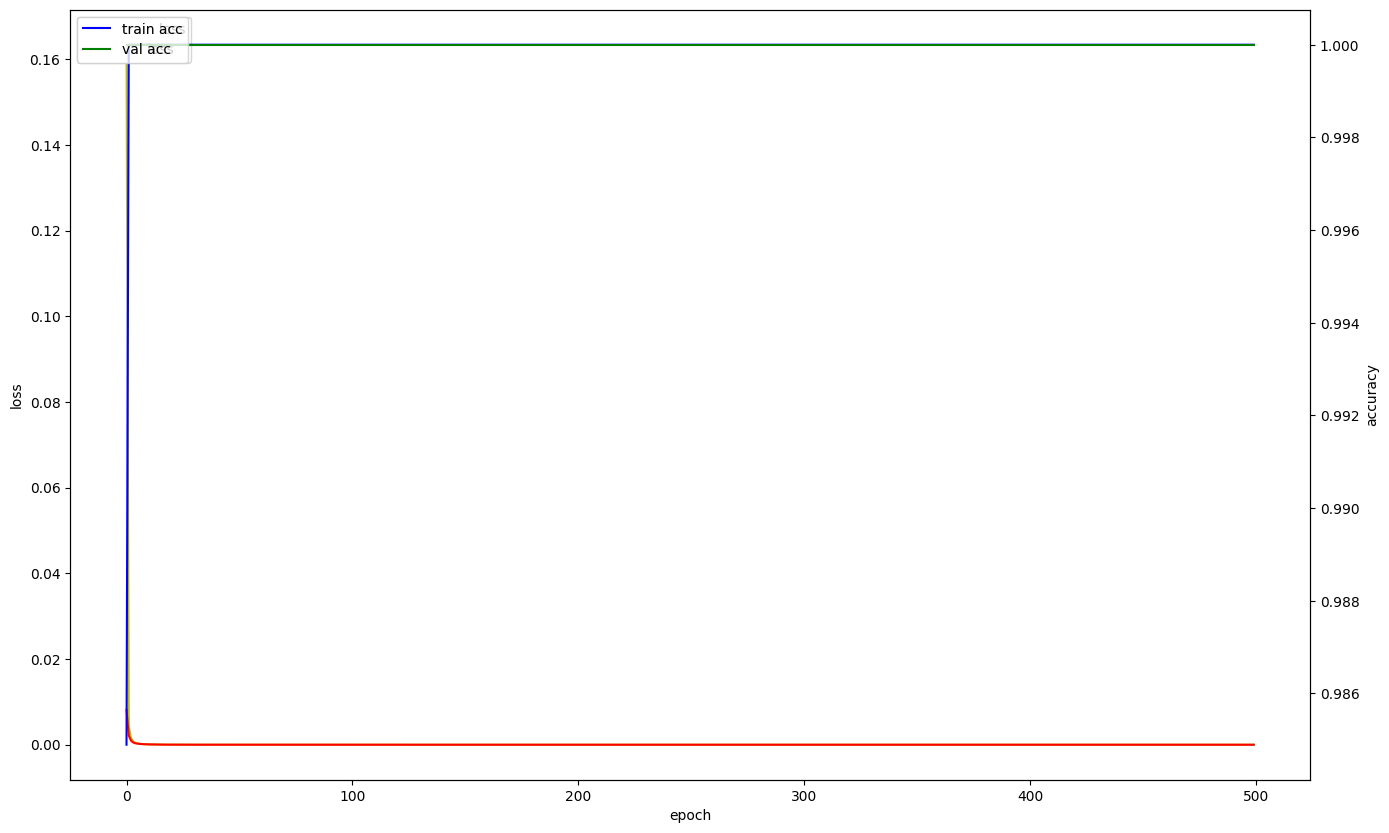

In [49]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [50]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

9/9 [==============================] - 0s 3ms/step


array([[[173,   0],
        [  0,  85]],

       [[178,   0],
        [  0,  80]],

       [[165,   0],
        [  0,  93]]], dtype=int64)